In [1]:
# basic packages
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import torch #had to pip install torch into venv, also scikit-learn, hydroeval, hydrotools
import torch.nn as nn

#Shared/Utility scripts
from model_scripts import Simple_Eval, dataloader, mlp_dataprocessing, mlp_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HOME = os.path.expanduser('~')


modelname = 'MLP'
model_path = f"{HOME}/SWEMLv2.0/Model/{modelname}"
if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)
print(f"{modelname} development script")

Device: cuda
Device: cuda
MLP development script


# Load data and set input columns

In [2]:
#load data
regionlist = ['SouthernRockies', 'Southwest', 'Northwest']
output_res = '300M_Resolution'
DataFrame = 'PrecipVIIRSGeoObsDFs'
fSCA_thresh = '20_fSCA_Thresh'

df = dataloader.get_ML_Data(regionlist, output_res, DataFrame, fSCA_thresh)
df.head()

Concatenating 14 for the model dataframe development.


  0%|          | 0/14 [00:00<?, ?it/s]

There are 305566 datapoints for model training/testing in the SouthernRockies modeling domain.
Concatenating 99 for the model dataframe development.


  0%|          | 0/99 [00:00<?, ?it/s]

There are 2222453 datapoints for model training/testing in the Southwest modeling domain.
Concatenating 2 for the model dataframe development.


  0%|          | 0/2 [00:00<?, ?it/s]

There are 170370 datapoints for model training/testing in the Northwest modeling domain.
There are 2698389 datapoints for model training/testing in the overall modeling domain.


,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,ns_3,ns_4,ns_5,ns_6,VIIRS_SCA,hasSnow,season_precip_cm,swe_cm,region,region_class
0,SouthernRockies_300M_37.355_-106.412,2015-04-06,37.355,-106.412,3028,5,180,16.5,18.5,42.7,46.2,34.3,0.0,41.50,True,30.4,0.000000,SouthernRockies,1
1,SouthernRockies_300M_37.26_-106.547,2015-04-06,37.260,-106.547,3009,15,264,16.5,18.5,46.2,42.7,34.3,0.0,57.75,True,31.4,3.805009,SouthernRockies,1
2,SouthernRockies_300M_37.26_-106.545,2015-04-06,37.260,-106.545,3025,19,329,16.5,18.5,46.2,42.7,34.3,0.0,57.75,True,31.4,6.861705,SouthernRockies,1
3,SouthernRockies_300M_37.26_-106.542,2015-04-06,37.260,-106.542,3024,20,351,16.5,18.5,46.2,42.7,34.3,0.0,68.00,True,31.4,10.765295,SouthernRockies,1
4,SouthernRockies_300M_37.26_-106.539,2015-04-06,37.260,-106.539,3083,15,333,16.5,18.5,46.2,42.7,34.3,0.0,68.50,True,31.4,2.078679,SouthernRockies,1


# Dataprocessing
* Editing the features based on the feature importance
* Remove headwater stations from dataset
* make sure dates are in datetime format

In [3]:
#clean the data
df = mlp_dataprocessing.data_clean(df, regionlist)
df.head()

#convert dates to datetime format
df.Date = pd.to_datetime(df.Date)

input_columns = [
            'cen_lat',	
            'cen_lon',	
            'Elevation_m',	
            'Slope_Deg',	
            'Aspect_Deg',	
            'ns_1',	
            'ns_2',	
            'ns_3',	
            'ns_4',	
            'ns_5',	
            'ns_6',	
            'VIIRS_SCA', 
            'hasSnow',
            'region_class'
]

years = False
splitratio = 0.33
test_years = [2019]
target = 'swe_cm'

#fit a scaler,save, and scale the training data
x_train_scaled, y_scaled_train, x_test_scaled, x_test, y_test = mlp_dataprocessing.mlp_scaler(
                                                    regionlist,
                                                      df, 
                                                      years, 
                                                      splitratio,
                                                      test_years, 
                                                      target, 
                                                      input_columns, 
                                                      model_path, 
                                                      scalertype = 'MinMax'
                                                      )

# Convert to tensor for PyTorch
x_train_scaled_t = torch.Tensor(x_train_scaled)
y_train_scaled_t = torch.Tensor(y_scaled_train)
x_test_scaled_t = torch.Tensor(x_test_scaled)
#Make sure the tensors on are the respective device (cpu/gpu)
x_train_scaled_t = x_train_scaled_t.to(device)
y_train_scaled_t = y_train_scaled_t.to(device)
x_test_scaled_t = x_test_scaled_t.to(device)

The provided data contains 2698389 data points, of which 383245 locations/timesteps show no SWE and VIIRS fsca > 20%
275006 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
150 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
183 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 2039955 datapoints for model training/testing.


,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,ns_3,ns_4,ns_5,ns_6,VIIRS_SCA,hasSnow,season_precip_cm,swe_cm,region,region_class
0,SouthernRockies_300M_37.26_-106.547,2015-04-06,37.26,-106.547,3009,15,264,16.5,18.5,46.2,42.7,34.3,0.0,57.75,True,31.4,3.805009,SouthernRockies,1
1,SouthernRockies_300M_37.26_-106.545,2015-04-06,37.26,-106.545,3025,19,329,16.5,18.5,46.2,42.7,34.3,0.0,57.75,True,31.4,6.861705,SouthernRockies,1
2,SouthernRockies_300M_37.26_-106.542,2015-04-06,37.26,-106.542,3024,20,351,16.5,18.5,46.2,42.7,34.3,0.0,68.00,True,31.4,10.765295,SouthernRockies,1
3,SouthernRockies_300M_37.26_-106.539,2015-04-06,37.26,-106.539,3083,15,333,16.5,18.5,46.2,42.7,34.3,0.0,68.50,True,31.4,2.078679,SouthernRockies,1
4,SouthernRockies_300M_37.26_-106.537,2015-04-06,37.26,-106.537,3133,11,308,16.5,18.5,46.2,42.7,34.3,0.0,64.75,True,31.4,4.483814,SouthernRockies,1


,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,ns_3,ns_4,ns_5,ns_6,VIIRS_SCA,hasSnow,season_precip_cm,swe_cm,region,region_class
248246,Southwest_300M_38.182_-119.597,2013-04-03,38.182,-119.597,1706,7,36,113.1,124.5,0.0,0.3,48.0,47.8,88.0,True,50.7,66.867477,Southwest,2
248247,Southwest_300M_38.015_-119.561,2013-04-03,38.015,-119.561,1835,16,169,75.5,113.1,39.6,21.4,28.4,51.1,63.0,True,53.8,48.456591,Southwest,2
248248,Southwest_300M_38.015_-119.564,2013-04-03,38.015,-119.564,1839,11,56,75.5,113.1,39.6,21.4,28.4,51.1,61.0,True,53.8,53.630471,Southwest,2
248249,Southwest_300M_38.015_-119.567,2013-04-03,38.015,-119.567,1841,5,127,75.5,113.1,39.6,21.4,28.4,124.5,68.5,True,53.8,49.717703,Southwest,2
248250,Southwest_300M_38.015_-119.57,2013-04-03,38.015,-119.570,1850,8,120,75.5,113.1,39.6,21.4,124.5,28.4,81.0,True,53.8,48.634857,Southwest,2


,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,ns_3,ns_4,ns_5,ns_6,VIIRS_SCA,hasSnow,season_precip_cm,swe_cm,region,region_class
1901057,Northwest_300M_48.09_-123.57,2016-02-08,48.090,-123.570,126,3,22,72.9,93.0,56.1,80.5,46.7,52.3,0.0,False,107.5,0.000000,Northwest,3
1901058,Northwest_300M_47.695_-123.508,2016-02-08,47.695,-123.508,1272,55,104,93.0,72.9,56.1,34.3,46.7,0.0,70.0,True,222.8,88.687057,Northwest,3
1901059,Northwest_300M_47.695_-123.511,2016-02-08,47.695,-123.511,1335,56,97,93.0,72.9,56.1,34.3,46.7,0.0,70.0,True,222.8,106.303192,Northwest,3
1901060,Northwest_300M_47.695_-123.514,2016-02-08,47.695,-123.514,1391,30,126,93.0,72.9,56.1,34.3,46.7,0.0,68.5,True,222.8,102.187645,Northwest,3
1901061,Northwest_300M_47.695_-123.516,2016-02-08,47.695,-123.516,1347,34,30,93.0,72.9,56.1,34.3,46.7,0.0,73.5,True,222.8,90.754303,Northwest,3


y train shape (1366768, 1)
x train shape (1366768, 14)
x test shape (673187, 14)


## Set up Testing year
* Select year(s) not used in training
* Convert to numpy array
* Load scaler and scale data
## Train the model
* randomize training data..
* add training loss https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/
## Loss functions
### Mean Absolute Error (MAE)
Regression problems, especially when the distribution of the target variable has outliers, such as small or big values that are a great distance from the mean value. It is considered to be more robust to outliers. PyTorch implementation as nn.L1Loss()

### Mean Squared Error (MSE)
The MSE, also called L2 Loss, computes the average of the squared differences between actual values and predicted values. Pytorch MSE Loss always outputs a positive result, regardless of the sign of actual and predicted values. To enhance the accuracy of the model, you should try to reduce the L2 Loss—a perfect value is 0.0.

The squaring implies that larger mistakes produce even larger errors than smaller ones. If the classifier is off by 100, the error is 10,000. If it’s off by 0.1, the error is 0.01. This punishes the model for making big mistakes and encourages small mistakes.

MSE is the default loss function for most Pytorch regression problems.

#### Make your own loss function
https://neptune.ai/blog/pytorch-loss-functions

Epochs completed:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/80, Loss: 0.008576455850688098
Epoch 2/80, Loss: 0.0045837125820224955
Epoch 3/80, Loss: 0.004515272079246598
Epoch 4/80, Loss: 0.004480422771832763
Epoch 5/80, Loss: 0.00445400084425985
Epoch 6/80, Loss: 0.00443106499411447
Epoch 7/80, Loss: 0.004410948764291184
Epoch 8/80, Loss: 0.0043917396194133925
Epoch 9/80, Loss: 0.00437378655036858
Epoch 10/80, Loss: 0.004357234159810073
Epoch 11/80, Loss: 0.00434199174047255
Epoch 12/80, Loss: 0.004328861073179938
Epoch 13/80, Loss: 0.0043158083639407725
Epoch 14/80, Loss: 0.004303888000991743
Epoch 15/80, Loss: 0.004292111779249145
Epoch 16/80, Loss: 0.004281698999276266
Epoch 17/80, Loss: 0.004270387134744514
Epoch 18/80, Loss: 0.004260160202365031
Epoch 19/80, Loss: 0.0042490324954114434
Epoch 20/80, Loss: 0.004238956527729819
Epoch 21/80, Loss: 0.004229426012172225
Epoch 22/80, Loss: 0.004219486497672787
Epoch 23/80, Loss: 0.004209858684751233
Epoch 24/80, Loss: 0.004200964447461535
Epoch 25/80, Loss: 0.004192285952030852
Epoch 26/

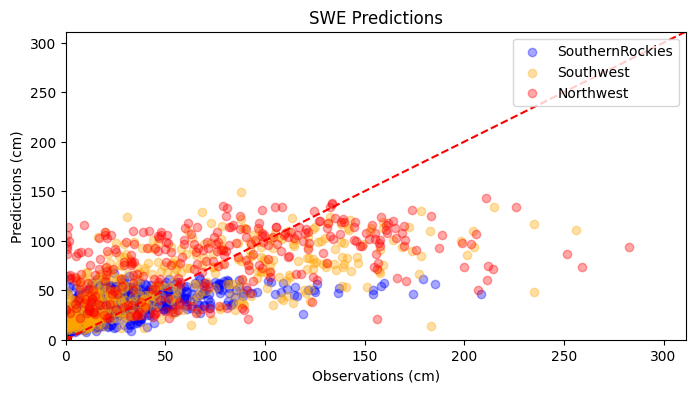

,region,MLP_swe_cm_kge,MLP_swe_cm_rmse,MLP_swe_cm_mape,MLP_swe_cm_pbias
0,Overall,0.71,25.0,189.05,-2.04
0,SouthernRockies,0.60,20.0,152.96,-5.05
0,Southwest,0.70,26.0,155.39,-0.93
0,Northwest,0.74,29.0,258.79,-0.80


In [4]:
epochs = 80 # - seems to converge around 80 epochs with 100 batrch size
batch_size = 80
learning_rate = 0.00001  # 0.0001,0.00001 look up learning rate scheduler https://www.geeksforgeeks.org/understanding-pytorch-learning-rate-scheduling/ -  smaller learning rates doing better!
decay = 0.00005 #0.0005, 0.00005
L1 = 20 #looked at 10,20,30,100
L2 = 20 #looked at 10,20,30,100
L3 = 100 #looked at 10,20,30,100
L4 = 100 #looked at 10,20,30,100
L5 = 100 #looked at 10,20,30,100
L6 = 18 #looked at 10,20,30,100
#can we train multiple models at a time here?
# 80	70	0.00001	0.00005	20	20	100	100	100	18 way better low value

search_params = epochs, batch_size, learning_rate, decay, L1, L2, L3, L4, L5, L6
loss_func = nn.MSELoss()
supply = False
layers = x_train_scaled_t.shape[1], L1, L2, L3, L4, L5, L6
params =  learning_rate, decay, epochs, batch_size
Use_fSCA_Threshold = True


# #Train the model
mlp_model.mlp_train(
    x_train_scaled_t,
    y_train_scaled_t, 
    layers, 
    params, 
    loss_func,
    model_path, 
    modelname, 
    shuffle = True)


 #Make a prediction for each location, save as compressed pkl file, and send predictions to AWS for use in CSES
PredsDF = pd.DataFrame()
PredsDF = mlp_model.mlp_predict(
                    layers, 
                    model_path, 
                    modelname, 
                    x_test,
                    x_test_scaled_t, 
                    y_test,
                    Use_fSCA_Threshold
                    )

#Take a sample to determine model skill - Take 1000 from each modeling domain
n_samples = 1000
SampleDF, PredsDF = Simple_Eval.SamplePreds(regionlist, PredsDF, df, n_samples)

 #Evaluate model performance of the different models
prediction_columns = [f"{modelname}_swe_cm"]
Eval_DF = Simple_Eval.Simple_Eval(regionlist,
                                SampleDF,
                                prediction_columns, 
                                modelname, 
                                plots = False, 
                                keystats = False        
                                )




In [33]:
SampleDF[(SampleDF['ASO_swe_cm']>1) & (SampleDF['ASO_swe_cm']<5)]

,cell_id,Date,region,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,ns_3,ns_4,ns_5,ns_6,VIIRS_SCA,hasSnow,region_class,ASO_swe_cm,MLP_swe_cm
51246,SouthernRockies_300M_37.614_-106.946,2015-04-07,SouthernRockies,37.614,-106.946,3580,54,312,33.5,41.7,0.0,20.6,17.5,15.5,50.000000,True,1,2.191927,17.581985
129674,SouthernRockies_300M_38.982_-106.589,2018-03-30,SouthernRockies,38.982,-106.589,3835,29,176,26.2,27.2,19.0,27.2,22.6,16.0,76.000000,True,1,2.167295,43.976929
109477,SouthernRockies_300M_37.627_-107.086,2016-04-03,SouthernRockies,37.627,-107.086,3599,9,254,17.3,42.4,67.1,66.5,50.3,36.6,56.500000,True,1,2.347442,18.726799
138489,SouthernRockies_300M_38.783_-107.082,2018-03-31,SouthernRockies,38.783,-107.082,3570,36,240,22.6,29.2,27.2,19.0,26.7,18.5,56.750000,True,1,1.608670,31.946260
94209,SouthernRockies_300M_37.816_-107.461,2015-06-02,SouthernRockies,37.816,-107.461,3166,34,310,3.6,0.0,0.0,42.7,5.3,10.4,78.500000,True,1,4.323887,38.462952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143173,Southwest_300M_37.829_-119.268,2016-05-09,Southwest,37.829,-119.268,3185,14,321,46.7,-9999.0,40.8,29.1,1.2,37.6,38.333333,True,2,3.908106,17.559561
373029,Southwest_300M_37.653_-119.491,2014-04-06,Southwest,37.653,-119.491,2962,14,21,16.2,23.6,20.7,3.8,18.7,12.5,45.000000,True,2,2.643774,21.778618
783298,Southwest_300M_38.053_-119.329,2015-03-25,Southwest,38.053,-119.329,1487,12,106,9.1,16.0,2.1,0.0,21.4,28.6,39.250000,True,2,1.221637,21.434195
410364,Southwest_300M_37.858_-119.423,2014-04-14,Southwest,37.858,-119.423,2727,59,312,17.2,36.3,13.2,23.2,29.0,-9999.0,85.000000,True,2,2.390874,74.123840
